In [10]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.image import imread

In [11]:
# Standard function we used in more programs to create a nice table using pandas df
#Everything important for ORB
def get_table(sims):
    """
    This function takes the output produced by either the compute_similarities 
    or compute_similarities_testsets function, and returns a pandas dataframe/table 
    and also saves it in excel.
    """
    
    data = {}
    rows = []

    for (key1, key2), value in sims.items():
        file1 = os.path.basename(key1).split('.')[0]
        file2 = os.path.basename(key2).split('.')[0]
        
        if file1 not in data:
            data[file1] = []
        if file2 not in rows:
            rows.append(file2)
        
        value = np.round(value, 3)
        data[file1].append(value)
        
    data = {key: value for key, value in sorted(data.items())}
    rows = sorted(rows)
    rows_indices_begin = list(range(len(rows)))
    data_values = list(data.values())
    rows_indices_end = sorted(rows_indices_begin, key=lambda i: rows[i])
    
    for key, value in data.items():
        new_value = []
        for i in rows_indices_end:
            new_value.append(value[i])
        data[key] = new_value
    
    df = pd.DataFrame(data, index=rows)
    return df.T

In [12]:
def orb_similarity(img1, img2):
    #Best parameters: (200, 1.1, 8, 3, 0, 41, 30)
    orb = cv2.ORB_create(nfeatures=200,scaleFactor=1.1,nlevels=8,WTA_K=3, 
                          scoreType=cv2.ORB_HARRIS_SCORE, patchSize=41, fastThreshold=30)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    if des1 is None or des2 is None:
        return 0.0

    # Use BFMatcher with default params
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # Match descriptors
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    # Apply RANSAC to find the best transformation
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    if len(matches) < 10:
         return 0.0
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15)
    matches_mask = mask.ravel().tolist()

    num_inliers = np.sum(matches_mask)
    num_matches = len(matches)
    
    similarity_percentage = (num_inliers / num_matches) * 100
    return similarity_percentage


In [13]:
def compute_similarities_testsets(munich_testset, nk_testset, 
                                  munich_path="munich_testset", 
                                  nk_path="nk_testset"):
    """
    Computes similarities between images from Munich and NK test sets using ORB features.
    """
    # Create an empty dictionary
    similarities = {}

    # Loop through all NK images
    for nk_img in nk_testset:
        nk_img_path = os.path.join(nk_path, nk_img)
        try:
            nk_img = cv2.imread(nk_img_path, cv2.IMREAD_GRAYSCALE)
            if nk_img is None:
                raise ValueError(f"Image at {nk_img_path} could not be loaded.")
        except ValueError as e:
            print(e)
            continue

        # Loop through all munich images
        for munich_img in munich_testset:
            munich_img_path = os.path.join(munich_path, munich_img)
            try:
                munich_img = cv2.imread(munich_img_path, cv2.IMREAD_GRAYSCALE)
                if munich_img is None:
                    raise ValueError(f"Image at {munich_img_path} could not be loaded.")
            except ValueError as e:
                print(e)
                continue
            # Create all matches and save them in the dictionary
            similarity = orb_similarity(nk_img, munich_img)
            similarities[(nk_img_path, munich_img_path)] = similarity
        
    return similarities

nk_path = "nk_testset"
munich_path = "munich_testset"
nk_path_no_back = "nk_testset_no_back"
munich_path_no_back = "munich_testset_no_back"

if not os.path.exists(nk_path):
    raise FileNotFoundError(f"The path {nk_path} does not exist.")
if not os.path.exists(munich_path):
    raise FileNotFoundError(f"The path {munich_path} does not exist.")

nk_testset = os.listdir(nk_path)
munich_testset = os.listdir(munich_path)
nk_testset_no_back = os.listdir(nk_path_no_back)
munich_testset_no_back = os.listdir(munich_path_no_back)

# Find all the 25 matches from the testset and create the table.
print("25 testset matches with regular background")
sims = compute_similarities_testsets(munich_testset, nk_testset, munich_path, nk_path)
get_table(sims)

25 testset matches with regular background


,card_table_mccp,chair_mccp,cupboard_mccp,dresser_mccp,table_mccp
card_table_nk,37.037,31.250,35.714,34.783,34.783
chair_nk,26.667,33.333,54.167,33.333,35.294
cupboard_nk,33.333,42.857,43.750,33.333,36.000
dresser_nk,35.484,57.143,41.935,41.379,31.579
table_nk,23.077,47.619,34.783,31.034,26.923


In [14]:
# Find all the 25 matches from the testset with no background and create the table.
print("25 testset matches with background removal")
sims = compute_similarities_testsets(munich_testset_no_back, nk_testset_no_back, munich_path_no_back, nk_path_no_back)
get_table(sims)

25 testset matches with background removal


,card_table_mccp,chair_mccp,cupboard_mccp,dresser_mccp,table_mccp
card_table_nk,50.000,26.667,33.333,35.000,36.667
chair_nk,46.154,29.167,66.667,26.923,34.783
cupboard_nk,44.444,28.571,45.000,32.143,30.769
dresser_nk,53.846,31.429,46.154,33.333,37.500
table_nk,39.130,30.435,40.000,24.138,39.130


In [15]:
def compute_similarities(nk_img_path, munich_imgs, path):
    """
    This function takes three arguments: 
    - nk_img, which is a single image from the nk collection. 
    - munich_imgs, this contains all images from the Munich Database. 
    - path, this is the path to the gray scaled Munich Database.
    
    It then computes the feature descriptor for the nk collection image and all the images in the \
    Munich Database. Afterwards takes the dot-product to get the dot-product similiarity. It then \
    saves the similarity and the two images as key-value pairs in a dictionary. 
    """
    
    nk_img = cv2.imread(nk_img_path, cv2.IMREAD_GRAYSCALE)
    similarities = {}
    i = 0

    for img_name in munich_imgs:
        if i == 500:
            break
        if i % 10 == 0:
            print(i)
        i += 1
        img_path = os.path.join(path, img_name)
        munich_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if nk_img is not None and munich_img is not None:
            similarity = orb_similarity(nk_img, munich_img)
            nk_img_name = os.path.basename(nk_img_path)
            munich_img_name = os.path.basename(img_path)
            similarities[(nk_img_name, munich_img_name)] = similarity

    return similarities

# Example usage
nk_img = "nk_testset/chair_nk.jpg"
munich_imgs = os.listdir("scraped_images_grayscaled_big")
path = "scraped_images_grayscaled_big"

# Only tested on first 50 images which already took 22 seconds. for 47.000 images this would take 5+ hours.
similarities = compute_similarities(nk_img, munich_imgs, path)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


Top 10 similar images for NK image 'chair_nk.jpg':


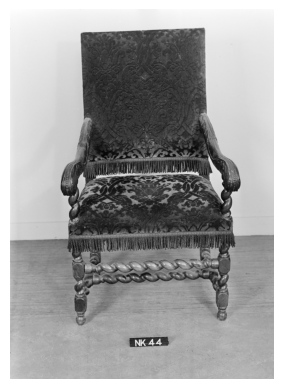

Munich image '2338_48320_id=cp166448_badv.jpg' (Similarity: 91.66666666666666)


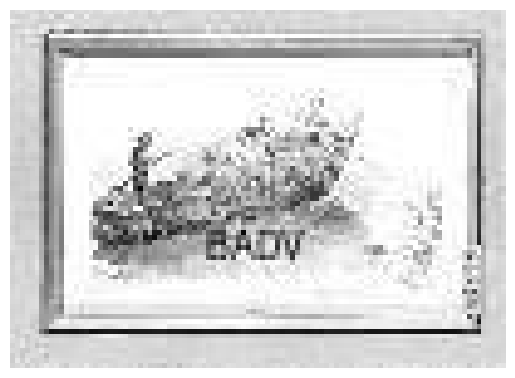

Munich image '1068_7950-36_id=cp173244_badv.jpg' (Similarity: 87.09677419354838)


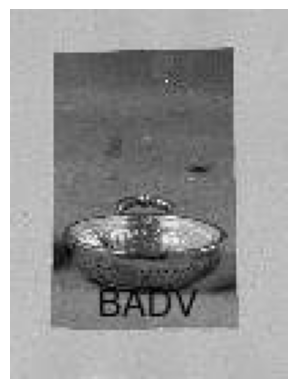

Munich image '2269_46550_id=cp164689_badv.jpg' (Similarity: 86.95652173913044)


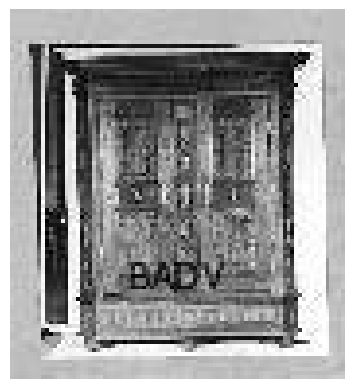

Munich image '2343_48426_id=cp166561_badv.jpg' (Similarity: 84.61538461538461)


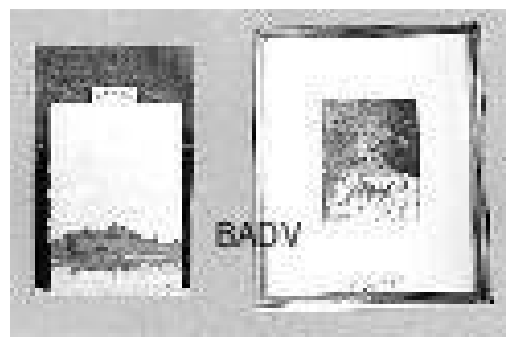

Munich image '0251_1371-47_id=cp140477_badv.jpg' (Similarity: 82.35294117647058)


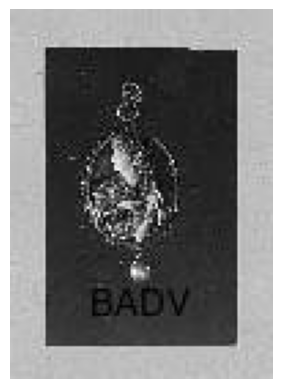

Munich image '1473_12385_id=cp138699_badv.jpg' (Similarity: 81.81818181818183)


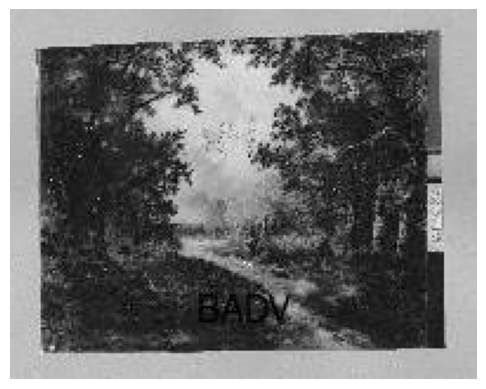

Munich image '2278_46799_id=cp164912_badv.jpg' (Similarity: 80.0)


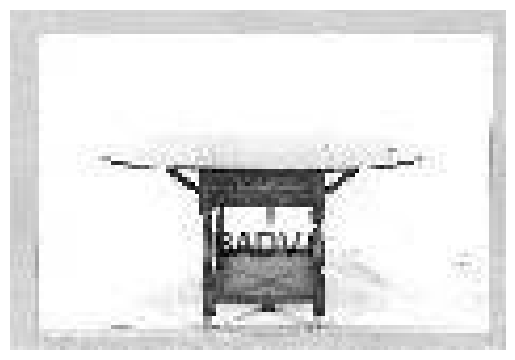

Munich image '1498_12963_id=cp139490_badv.jpg' (Similarity: 80.0)


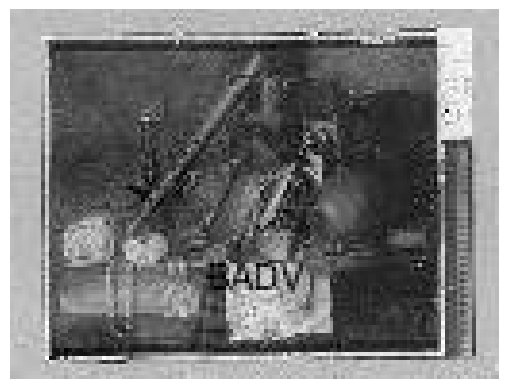

Munich image '2141_43612_id=cp161752_badv.jpg' (Similarity: 80.0)


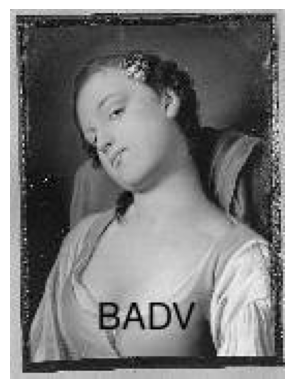

Munich image '2296_47346_id=cp165485_badv.jpg' (Similarity: 76.47058823529412)


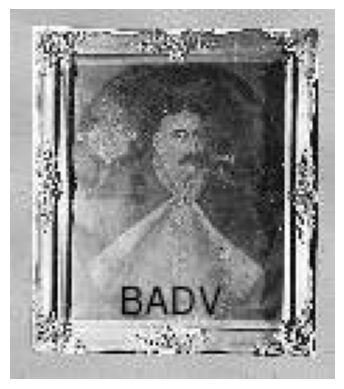

In [16]:
def get_top_10_similarities(similarities):
    """
    Get the top 10 highest similarity values for each NK image from the similarities dictionary.
    
    Parameters:
    - similarities: A dictionary where keys are (NK image name, Munich image name) tuples
                    and values are similarity scores.
                    
    Returns:
    - A dictionary where keys are NK image names and values are lists of tuples
      (Munich image name, similarity) sorted by similarity in descending order.
    """
    top_10_similarities = {}
    
    for nk_img_name in set(key[0] for key in similarities.keys()):
        # Filter similarities for current NK image
        nk_similarities = [(munich_img_name, similarity) for (nk, munich_img_name), similarity in similarities.items() if nk == nk_img_name]
        
        # Sort by similarity in descending order
        sorted_similarities = sorted(nk_similarities, key=lambda x: x[1], reverse=True)
        
        # Get top 10 similarities
        top_10_similarities[nk_img_name] = sorted_similarities[:10]
    
    return top_10_similarities

def display_image(image_path):
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def display_nk_image(nk_img_name):
    image_path = f"{nk_path}/{nk_img_name}"
    image = imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

top_10 = get_top_10_similarities(similarities)
for nk_img_name, similar_images in top_10.items():
    print(f"Top 10 similar images for NK image '{nk_img_name}':")
    display_nk_image(nk_img_name)
    for munich_img_name, similarity in similar_images:
        image_path = f"scraped_images_grayscaled_big/{munich_img_name}"
        print(f"Munich image '{munich_img_name}' (Similarity: {similarity})")
        display_image(image_path)
        
# This only looks at the first 1000 images from the large dataset.
# We are getting some really high similarities for objects that do not resemble the chair in the slightest
# We dropped ORB, not because of lack of speed but because of lack of accurarcy.

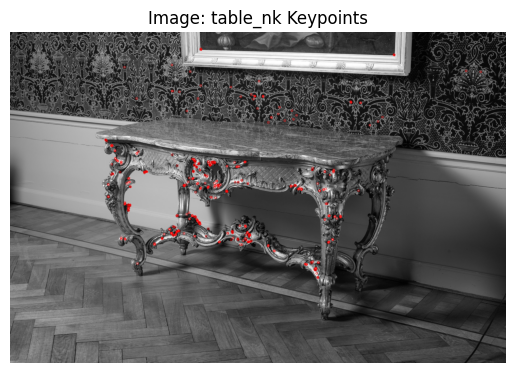

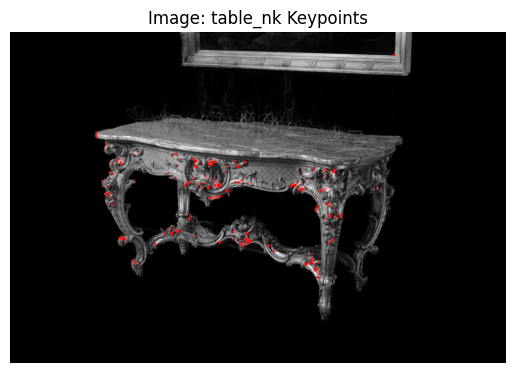

In [17]:
def visualize_keypoints(image_path):
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("The image path is invalid.")

    orb = cv2.ORB_create()

    # Detect keypoints and descriptors with ORB
    kp, des = orb.detectAndCompute(img, None)
    len(kp)
    # Draw keypoints on the image
    img_with_keypoints = cv2.drawKeypoints(img, kp, None, color=(255, 0, 0), flags=cv2.DrawMatchesFlags_DEFAULT)

    # Display the image with keypoints
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title(f'Image: {image_name(image_path)} Keypoints')
    plt.axis('off')
    plt.show()

def image_name(image_path):
    return os.path.splitext(os.path.basename(image_path))[0]

visualize_keypoints("nk_testset/table_nk.jpg")
visualize_keypoints("nk_testset_no_back/table_nk.jpg")

In [ ]:
import itertools


# List to hold the images
images_nk = []
images_mccp = []

# Loop through the files in the directory and save the names and the path
for filename in os.listdir(nk_path):
    file_path = os.path.join(nk_path, filename)
    images_nk.append((filename, file_path))

for filename in os.listdir(munich_path):
    file_path = os.path.join(munich_path, filename)
    images_mccp.append((filename, file_path))

def test_orb_parameters(images_nk, images_mccp):
    """
    Tests all combinations off features tot find the best one.
    Uses a reinforcement learning technique that provides a positive reward for 
    matches that we want (table and table) but a negative reward for matches we
    dont want (table and chair)
    """
    nfeatures_list = [100, 200, 500, 800, 1000]
    scaleFactor_list = [1.1, 1.2, 1.3]
    nlevels_list = [4, 8, 12]
    WTA_K_list = [2, 3, 4]
    scoreType_list = [cv2.ORB_HARRIS_SCORE, cv2.ORB_FAST_SCORE]
    patchSize_list = [21, 31, 41]
    fastThreshold_list = [10, 20, 30]
    
    best_similarity = -1000
    best_params = None
    
    # Loops through all possible parameters
    for nfeatures, scaleFactor, nlevels, WTA_K, scoreType, patchSize, fastThreshold in itertools.product(
            nfeatures_list, scaleFactor_list, nlevels_list, WTA_K_list, scoreType_list, patchSize_list, fastThreshold_list):
        
        orb = cv2.ORB_create(nfeatures=nfeatures, scaleFactor=scaleFactor, nlevels=nlevels, WTA_K=WTA_K, 
                             scoreType=scoreType, patchSize=patchSize, fastThreshold=fastThreshold)
        similarity_score = 0

        # Go through all images
        for filename_nk, image_path1 in images_nk:
            for filename_mccp, image_path2 in images_mccp:
                same_item = False
                if filename_nk[:2].lower() == filename_mccp[:2].lower():
                    same_item = True
                kp1, des1 = extract_orb_features(image_path1, orb)
                kp2, des2 = extract_orb_features(image_path2, orb)
                
                if des1 is None or des2 is None:
                    continue
                
                matches = match_descriptors(des1, des2)
                if len(matches) < 4:
                    continue
                
                src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
                
                H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15)
                if mask is None:
                    continue
                
                matches_mask = mask.ravel().tolist()
                num_inliers = np.sum(matches_mask)
                num_matches = len(matches)
                # If it is the same item we give it a positive reward
                if same_item:
                    similarity_score += (num_inliers / num_matches) * 100 * 4 # multiply by 4 to even out negative and positive weights (there are 4 times as many non matches than actual matches)
                else:
                    similarity_score -= (num_inliers / num_matches) * 100
        
        if similarity_score > best_similarity:
            best_similarity = similarity_score
            best_params = (nfeatures, scaleFactor, nlevels, WTA_K, scoreType, patchSize, fastThreshold)
    
    return best_similarity, best_params


def extract_orb_features(image_path, orb):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    kp, des = orb.detectAndCompute(img, None)
    return kp, des

def match_descriptors(des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches

# Example usage:
best_similarity, best_params = test_orb_parameters(images_nk, images_mccp)
print("Best similarity:", best_similarity)
print("Best parameters:", best_params)

# This code was run once before and takes 55 minutes to run, it is unoptimized but only used to run once.
# Parameters found were: (200, 1.1, 8, 3, 0, 41, 30)